<br>
<h2 style = "font-size:30px; font-family:Montserrat ; font-weight : bold; background-color: #0059b3; color :#fffae6   ; text-align: center; border-radius: 5px 5px; padding: 10px">Text Clustering Based On Movies Overview</h2>
<br>

<h2 style = "font-size:27px; font-family:Montserrat ; font-weight : bold; background-color: #0059b3; color :#fffae6  ; text-align: center; border-radius: 5px 5px; padding: 7px">Table of Contents</h2>

   #### [1. Dataset Introduction](#1)
   #### [2. Data Preprocessing](#2)
   #### [3. K-Means Clustering](#3)
   #### [4. Hierarchical Clustering](#4)
   #### [5. DBSCAN](#5)

<a id="1"></a>
<h2 style = "font-size:27px; font-family:Montserrat ; font-weight : bold; background-color: #0059b3; color :#ffefe5   ; text-align: center; border-radius: 5px 5px; padding: 7px">1. Dataset Introduction</h2>

#### Movies Dataset

<b>Description:</b><br>
<b>

This dataset consists of information about various movies, with each row representing a different movie.<br><br>


<b>Attributes:</b><br>
   - <b>id</b>: A unique identifier for each movie<br>
   - <b>title</b>: The title of the movie
   - <b>overview</b>: A brief summary or description of the movie's plot or main storyline<br>
  
</p>

<a id="2"></a>
<h2 style = "font-size:27px; font-family:Montserrat ; font-weight : bold; background-color: #0059b3; color :#fffae6   ; text-align: center; border-radius: 5px 5px; padding: 7px">2. Data Preprocessing</h2>

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
from PIL import Image
from wordcloud import WordCloud
from scipy.cluster.hierarchy import dendrogram, linkage

import warnings
warnings.filterwarnings('ignore')

### Load data

In [2]:
data = pd.read_csv("Movies_Dataset.csv")

In [3]:
data.head()

,id,title,overview
0,0,Toy Story,"Led by Woody, Andy's toys live happily in his ..."
1,1,Jumanji,When siblings Judy and Peter discover an encha...
2,2,Grumpier Old Men,A family wedding reignites the ancient feud be...
3,3,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom..."
4,4,Father of the Bride Part II,Just when George Banks has recovered from his ...


In [4]:
data.drop(['id'], axis = 1, inplace = True)

In [5]:
data.shape

(45466, 2)

In [6]:
data = data.head(15000)

In [7]:
data.shape

(15000, 2)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     15000 non-null  object
 1   overview  14936 non-null  object
dtypes: object(2)
memory usage: 234.5+ KB


### Missing values

In [9]:
missing_count = data.isnull().sum()
missing_percentage = (data.isnull().sum() / len(data)) * 100

In [10]:
missing_data = pd.DataFrame({
    'feature': missing_percentage.index,
    'missing count': missing_count.values,
    'missing %': missing_percentage.values})

In [11]:
missing_data

,feature,missing count,missing %
0,title,0,0.000000
1,overview,64,0.426667


In [12]:
# Drop rows with missing values in the 'overview' column
data.dropna(subset=['overview'], inplace=True)

In [13]:
# Resetting index after dropping rows
data.reset_index(drop=True, inplace=True)

In [14]:
data.isna().sum()

title       0
overview    0
dtype: int64

### Missing values

In [15]:
def clean_text(text):
    # Removing HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Lowercasing
    text = text.lower()
    
    # Removing punctuation and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    
    # Return the cleaned string
    return text

In [16]:
# Apply cleaning to the 'overview' column
data['clean_overview'] = data['overview'].apply(clean_text)

### Tokenisation

In [17]:
data['clean_overview'] = data['clean_overview'].apply(lambda x: word_tokenize(x))

In [18]:
data

,title,overview,clean_overview
0,Toy Story,"Led by Woody, Andy's toys live happily in his ...","[led, by, woody, andys, toys, live, happily, i..."
1,Jumanji,When siblings Judy and Peter discover an encha...,"[when, siblings, judy, and, peter, discover, a..."
2,Grumpier Old Men,A family wedding reignites the ancient feud be...,"[a, family, wedding, reignites, the, ancient, ..."
3,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...","[cheated, on, mistreated, and, stepped, on, th..."
4,Father of the Bride Part II,Just when George Banks has recovered from his ...,"[just, when, george, banks, has, recovered, fr..."
...,...,...,...
14931,The Bone Man,"Set in a sleepy Austrian mountain village, ex-...","[set, in, a, sleepy, austrian, mountain, villa..."
14932,Scar,Joan Burrows returns to her hometown for her n...,"[joan, burrows, returns, to, her, hometown, fo..."
14933,I Hate Valentine's Day,"A love story set in Manhattan, where a florist...","[a, love, story, set, in, manhattan, where, a,..."
14934,�_i�_ek!,�_I�_EK! trails the thinker as he crisscrosses...,"[iek, trails, the, thinker, as, he, crisscross..."


### Stopwords

In [19]:
data['clean_overview'] = data['clean_overview'].apply(lambda x: [i for i in x if i not in stopwords.words('english')])

### Lemmatisation

In [20]:
lemmatizer = WordNetLemmatizer()

In [21]:
data['clean_overview'] = data['clean_overview'].apply(lambda tokens: [lemmatizer.lemmatize(word) for word in tokens])

In [22]:
data

,title,overview,clean_overview
0,Toy Story,"Led by Woody, Andy's toys live happily in his ...","[led, woody, andys, toy, live, happily, room, ..."
1,Jumanji,When siblings Judy and Peter discover an encha...,"[sibling, judy, peter, discover, enchanted, bo..."
2,Grumpier Old Men,A family wedding reignites the ancient feud be...,"[family, wedding, reignites, ancient, feud, ne..."
3,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...","[cheated, mistreated, stepped, woman, holding,..."
4,Father of the Bride Part II,Just when George Banks has recovered from his ...,"[george, bank, recovered, daughter, wedding, r..."
...,...,...,...
14931,The Bone Man,"Set in a sleepy Austrian mountain village, ex-...","[set, sleepy, austrian, mountain, village, exd..."
14932,Scar,Joan Burrows returns to her hometown for her n...,"[joan, burrow, return, hometown, niece, gradua..."
14933,I Hate Valentine's Day,"A love story set in Manhattan, where a florist...","[love, story, set, manhattan, florist, abides,..."
14934,�_i�_ek!,�_I�_EK! trails the thinker as he crisscrosses...,"[iek, trail, thinker, crisscross, globe, racin..."


### Vectorisation: Tfidf

In [23]:
# Creates a list comprehension that joins the lemmatized words in each document with spaces
# Resulting in a list of strings (each string represents a document)
X = [' '.join(doc) for doc in data['clean_overview']]

In [24]:
tfidf_vectorizer = TfidfVectorizer()

In [25]:
X_tfidf = tfidf_vectorizer.fit_transform(X)

In [26]:
X_tfidf.shape

(14936, 40872)

### Dimensionality reduction using PCA

In [27]:
# Perform dimensionality reduction because of curse of dimensionality 
# Choose 2 components for the sake of result interpretation
pca = PCA(n_components = 2)

In [28]:
X_tfidf_pca = pca.fit_transform(X_tfidf.toarray())

In [29]:
data['pca_tfidf_1'] = pd.DataFrame(X_tfidf_pca)[0]
data['pca_tfidf_2'] = pd.DataFrame(X_tfidf_pca)[1]

In [30]:
data

,title,overview,clean_overview,pca_tfidf_1,pca_tfidf_2
0,Toy Story,"Led by Woody, Andy's toys live happily in his ...","[led, woody, andys, toy, live, happily, room, ...",-0.028653,-0.016598
1,Jumanji,When siblings Judy and Peter discover an encha...,"[sibling, judy, peter, discover, enchanted, bo...",-0.027468,-0.025345
2,Grumpier Old Men,A family wedding reignites the ancient feud be...,"[family, wedding, reignites, ancient, feud, ne...",0.003171,-0.025950
3,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...","[cheated, mistreated, stepped, woman, holding,...",0.056841,-0.009200
4,Father of the Bride Part II,Just when George Banks has recovered from his ...,"[george, bank, recovered, daughter, wedding, r...",0.015360,-0.031773
...,...,...,...,...,...
14931,The Bone Man,"Set in a sleepy Austrian mountain village, ex-...","[set, sleepy, austrian, mountain, village, exd...",-0.024756,-0.031595
14932,Scar,Joan Burrows returns to her hometown for her n...,"[joan, burrow, return, hometown, niece, gradua...",-0.000228,-0.055845
14933,I Hate Valentine's Day,"A love story set in Manhattan, where a florist...","[love, story, set, manhattan, florist, abides,...",0.072015,0.053762
14934,�_i�_ek!,�_I�_EK! trails the thinker as he crisscrosses...,"[iek, trail, thinker, crisscross, globe, racin...",-0.021903,-0.023966


<a id="3"></a>
<h2 style = "font-size:27px; font-family:Montserrat ; font-weight : bold; background-color: #0059b3; color :#fffae6   ; text-align: center; border-radius: 5px 5px; padding: 7px">2. K-Means Clustering</h2>

### Determine k using Elbow Method

In [31]:
k_values = range(2,10)

In [32]:
# Within-cluster sum of squares
inertia_values = []

# Quality of cluster separation
silhouette_scores = []

In [33]:
# Fit KMeans for each k and store inertia and silhouette scores
for i in k_values:
    model_kmeans = KMeans(n_clusters = i, random_state = 1)
    model_kmeans.fit_predict(X_tfidf_pca)
    cluster_kmeans = model_kmeans.labels_

    # Inertia
    inertia_values.append(model_kmeans.inertia_)
    
    # Silhouette Score
    silhouette_scores.append(silhouette_score(data[['pca_tfidf_1','pca_tfidf_2']], cluster_kmeans))

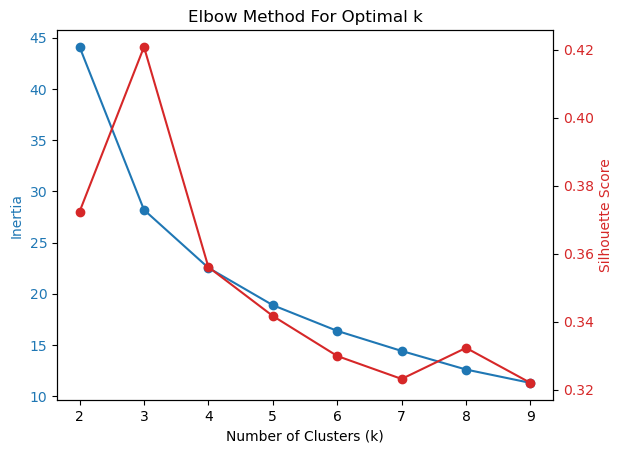

In [34]:
# Plot the elbow curve
fig, ax1 = plt.subplots()

ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia', color = 'tab:blue')
ax1.plot(range(2,10), inertia_values, marker = 'o', color = 'tab:blue')
ax1.tick_params(axis = 'y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Silhouette Score', color = 'tab:red')
ax2.plot(range(2,10), silhouette_scores, marker = 'o', color = 'tab:red')
ax2.tick_params(axis = 'y', labelcolor = 'tab:red')

plt.title('Elbow Method For Optimal k')
plt.show()

### Determine Elbow using KneeLocator Library

In [35]:
kl = KneeLocator(k_values, inertia_values, curve = "convex", direction = "decreasing")

In [36]:
kl.elbow

4

In [37]:
kl_ss = KneeLocator(k_values, silhouette_scores, curve = "concave", direction = "increasing")

In [38]:
kl_ss.elbow

3

### k = 3

In [39]:
k = 3
model_kmeans = KMeans(n_clusters = k, random_state = 1)
model_kmeans.fit_predict(X_tfidf_pca)

array([2, 2, 2, ..., 1, 2, 2])

In [40]:
data['cluster_kmeans'] = model_kmeans.labels_

<Axes: xlabel='pca_tfidf_1', ylabel='pca_tfidf_2'>

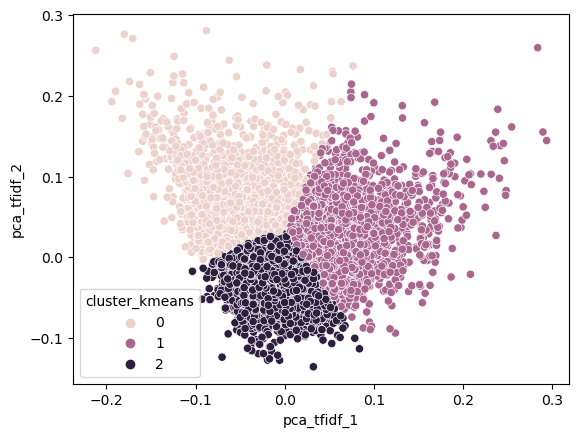

In [41]:
sns.scatterplot(data, x = data['pca_tfidf_1'], y = data['pca_tfidf_2'], hue = 'cluster_kmeans')

In [42]:
silhouette_score(X_tfidf_pca, model_kmeans.labels_)

0.42080377355479925

In [43]:
wordcloud_list = [data[data['cluster_kmeans'] == i]['clean_overview'] for i in data['cluster_kmeans'].unique()]
wordcloud1 = ' '.join([word for sublist in wordcloud_list[0] for word in sublist])
wordcloud2 = ' '.join([word for sublist in wordcloud_list[1] for word in sublist])
wordcloud3 = ' '.join([word for sublist in wordcloud_list[2] for word in sublist])

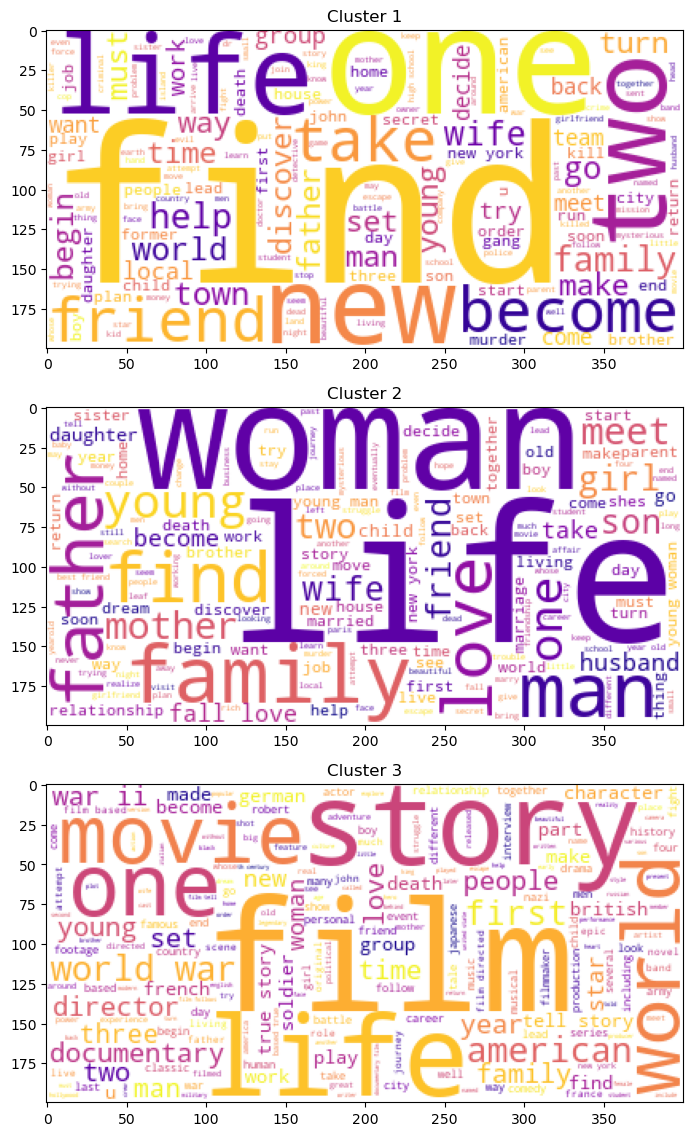

In [44]:
wordcloud_list = [wordcloud1, wordcloud2, wordcloud3]
title = ['1', '2', '3']

plt.figure(figsize=(20, 15))  
for i, j in enumerate(wordcloud_list):
    plt.subplot(4, 1, i + 1)    
    wc = WordCloud(background_color='white', colormap='plasma').generate(j)
    plt.imshow(wc)
    plt.title(f'Cluster {title[i]}')

plt.tight_layout()
plt.show()

<a id="3"></a>
<h2 style = "font-size:27px; font-family:Montserrat ; font-weight : bold; background-color: #0059b3; color :#fffae6   ; text-align: center; border-radius: 5px 5px; padding: 7px">3. Hierarchical Clustering</h2>

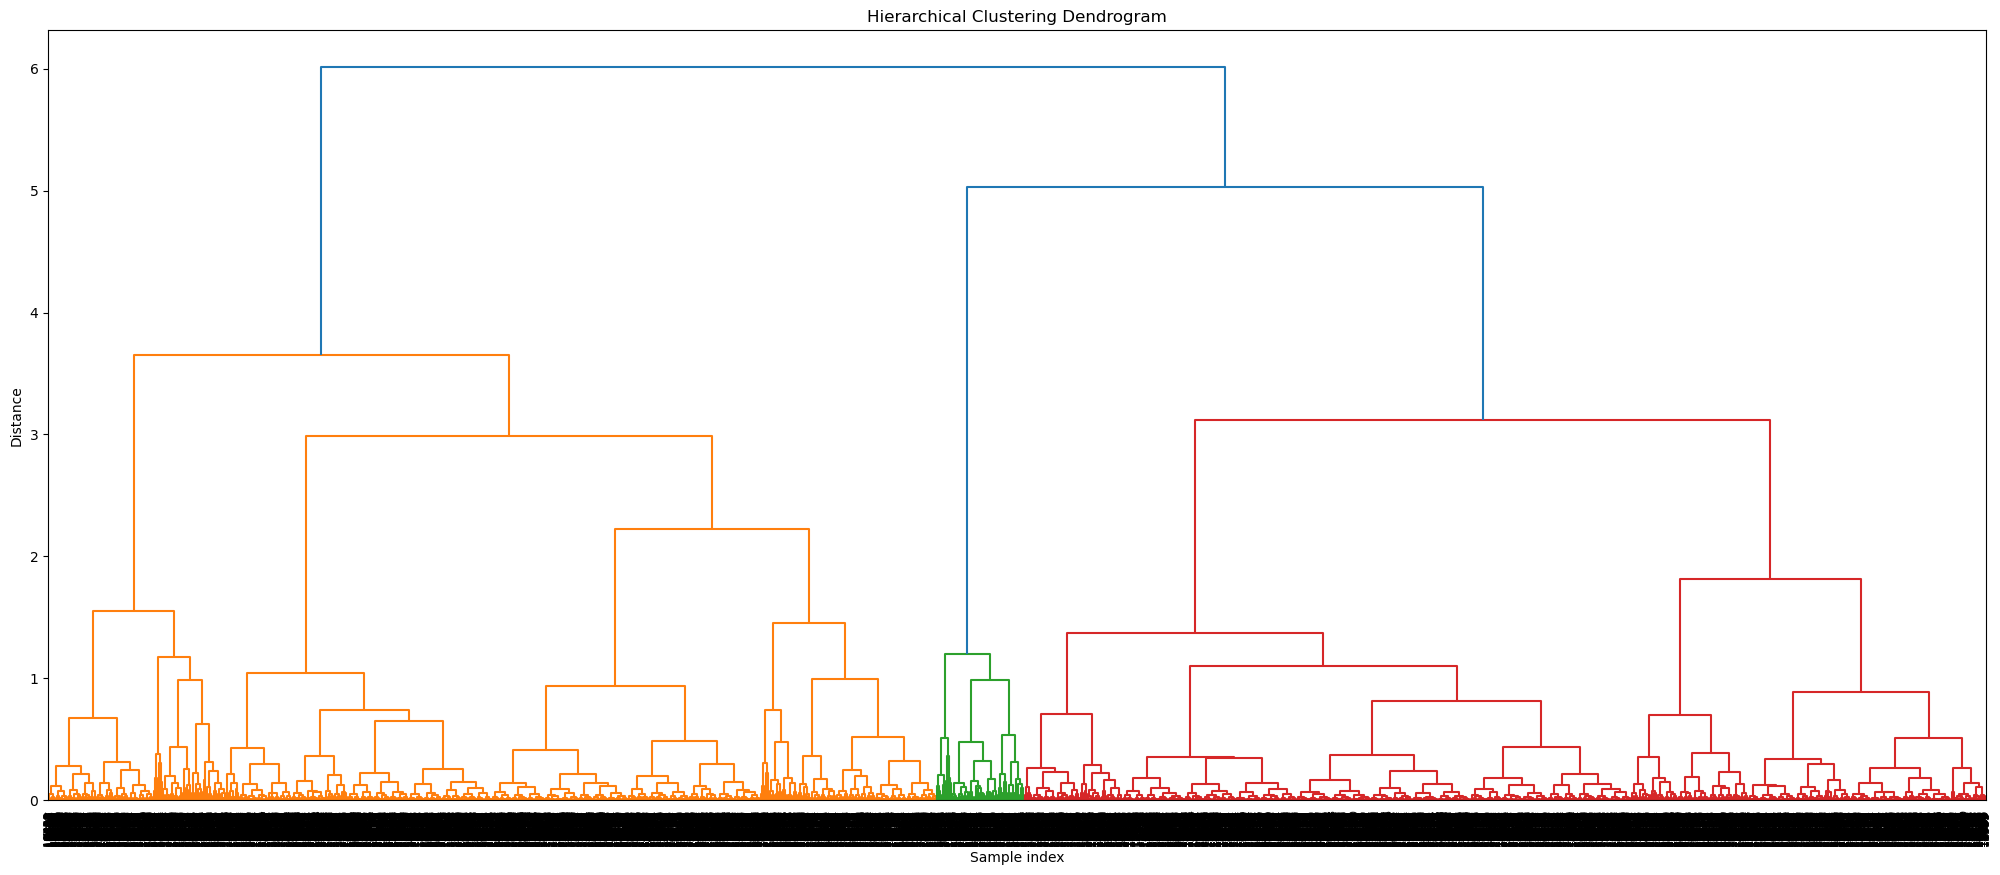

In [45]:
# Linkage matrix
linkage_matrix = linkage(X_tfidf_pca, method='ward')

# Plot dendrogram
plt.figure(figsize = (25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
dendrogram(
    linkage_matrix,
    leaf_rotation = 90.,  # Rotates the x axis labels
    leaf_font_size = 8.,  # Font size for the x axis labels
)

plt.show()

### n = 3

In [46]:
n = 3
model_hierarchical = AgglomerativeClustering(n_clusters = n)
model_hierarchical.fit_predict(X_tfidf_pca)

array([1, 1, 1, ..., 0, 1, 1], dtype=int64)

In [47]:
data['cluster_hierarchichal'] = model_hierarchical.labels_

In [48]:
silhouette_score(X_tfidf_pca, model_hierarchical.labels_)

0.31622321305009116

<Axes: xlabel='pca_tfidf_1', ylabel='pca_tfidf_2'>

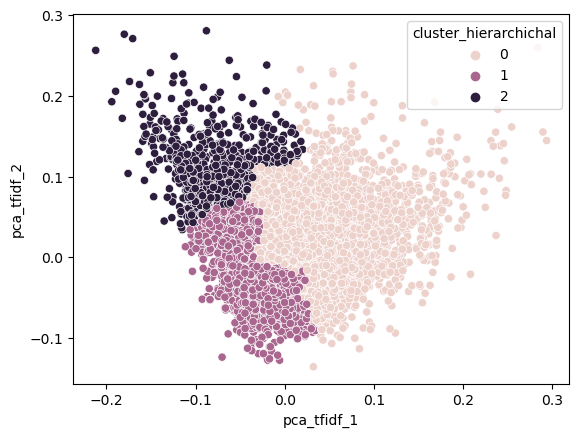

In [49]:
sns.scatterplot(data, x = data['pca_tfidf_1'], y = data['pca_tfidf_2'], hue = 'cluster_hierarchichal')

### n = 4

In [50]:
n = 4
model_hierarchical = AgglomerativeClustering(n_clusters = n)
model_hierarchical.fit_predict(X_tfidf_pca)

array([0, 0, 0, ..., 3, 0, 0], dtype=int64)

In [51]:
data['cluster_hierarchichal'] = model_hierarchical.labels_

In [52]:
silhouette_score(X_tfidf_pca, model_hierarchical.labels_)

0.28587617783993385

<Axes: xlabel='pca_tfidf_1', ylabel='pca_tfidf_2'>

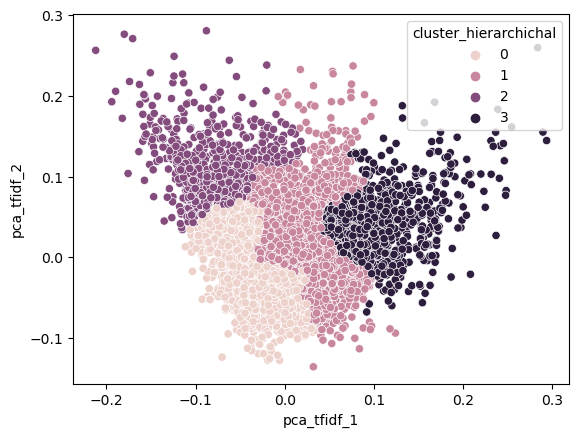

In [53]:
sns.scatterplot(data, x = data['pca_tfidf_1'], y = data['pca_tfidf_2'], hue = 'cluster_hierarchichal')

<a id="3"></a>
<h2 style = "font-size:27px; font-family:Montserrat ; font-weight : bold; background-color: #0059b3; color :#fffae6   ; text-align: center; border-radius: 5px 5px; padding: 7px">4. DBSCAN</h2>

### Determine optimal epsilon using Nearest Neighbors

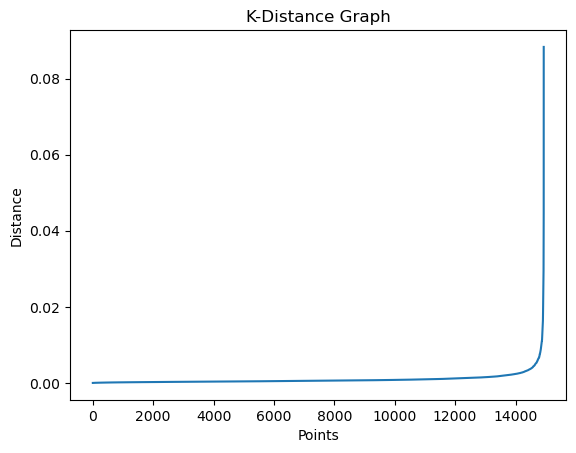

In [54]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
import numpy as np

# We'll use NearestNeighbors to find the optimal value of epsilon (eps)
# As per the reference, min_samples is usually set to 2 * the dimensionality of the dataset
# Since the data is reduced to 2 dimensions with PCA, min_samples will start from 4

# First prepare the data which is already PCA reduced
X = np.array(data[['pca_tfidf_1', 'pca_tfidf_2']])

# Then, calculate the distance to the nearest n points for each point
min_samples = 4
nearest_neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = nearest_neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

# Sort distance values by ascending value and plot
distances = np.sort(distances, axis=0)
distances = distances[:,1]  # Take the distances to the k-th nearest points (min_samples-1)

plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance")
plt.title("K-Distance Graph")
plt.show()

In [55]:
from kneed import KneeLocator

# Convert the distance array into a list for the KneeLocator
distances_list = distances.tolist()

# Use KneeLocator to find the knee (elbow) point on the curve
# curve='convex' and direction='increasing' because the graph is convex and increasing to the knee
knee_locator = KneeLocator(range(len(distances_list)), distances_list, curve='convex', direction='increasing')

# Find the index of the knee point
knee_point = knee_locator.knee

# The optimal epsilon is the distance at the knee point
optimal_eps = distances_list[knee_point]

print(f'Optimal epsilon (eps) value: {optimal_eps}')


Optimal epsilon (eps) value: 0.015204852546722757


min_samples = 4
Number of clusters created: 5
Silhouette Score: 0.5280946651446932


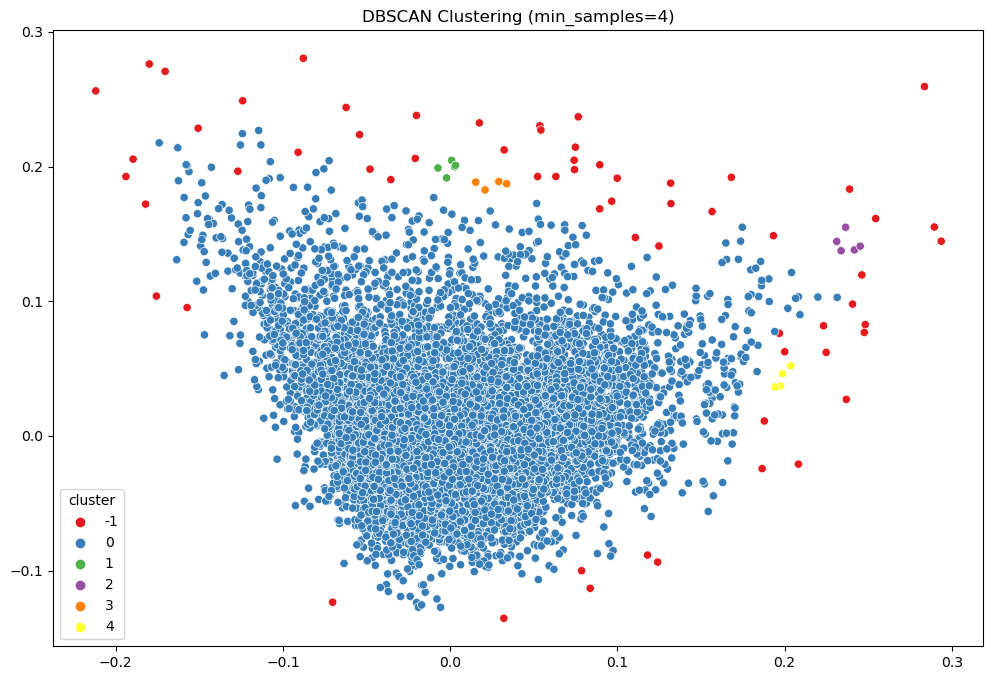

min_samples = 6
Number of clusters created: 2
Silhouette Score: 0.49646271554973737


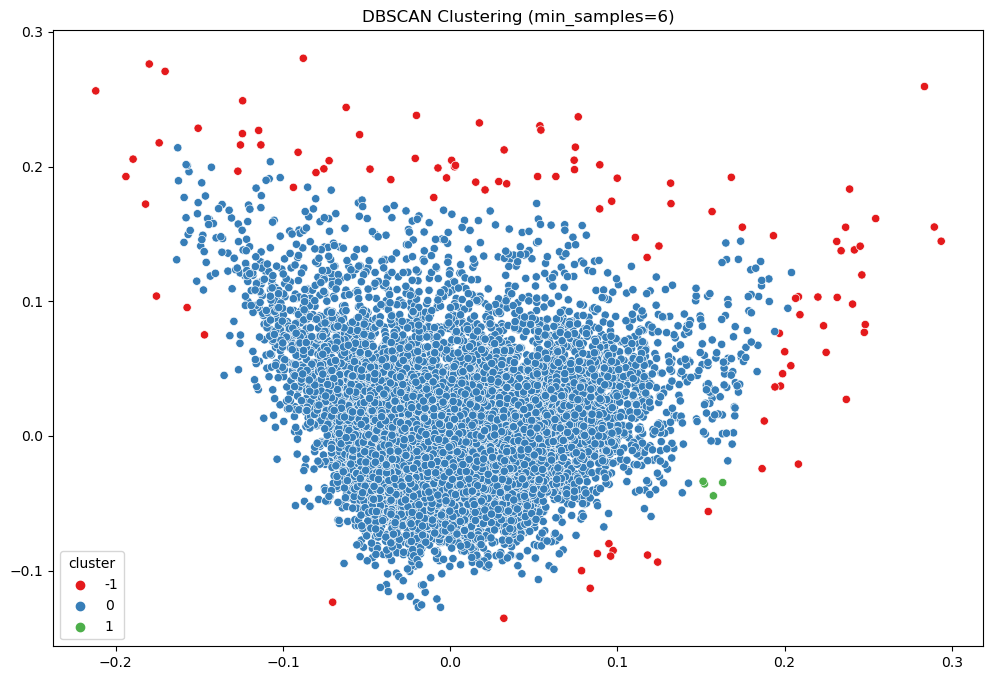

min_samples = 8
Number of clusters created: 2
Silhouette Score: 0.6082646870210372


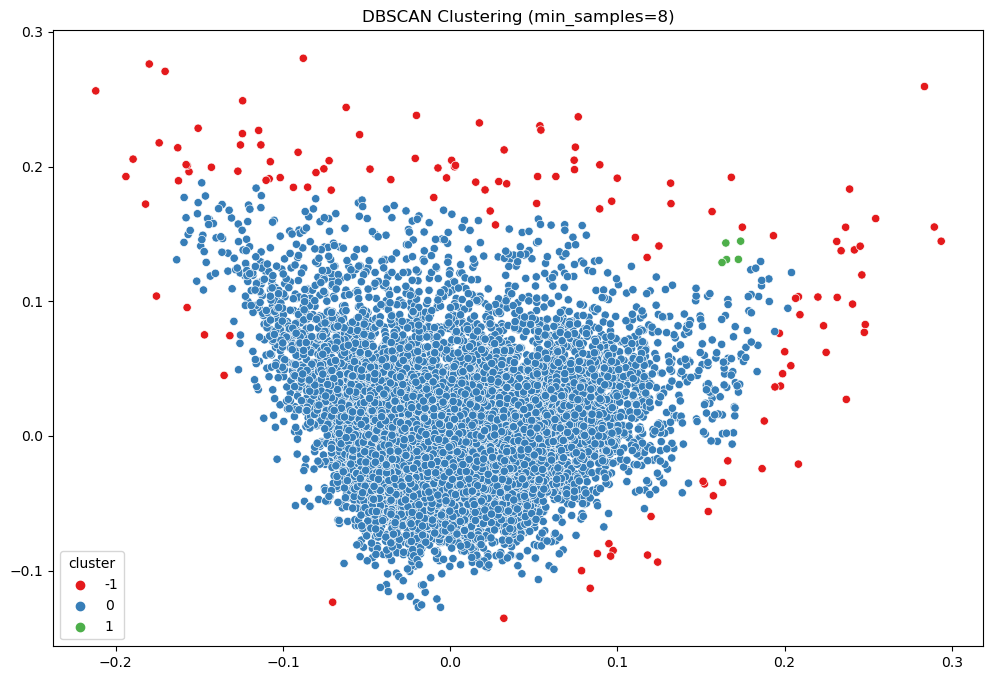

min_samples = 12
Number of clusters created: 1
Silhouette Score: 0.6406651383207258


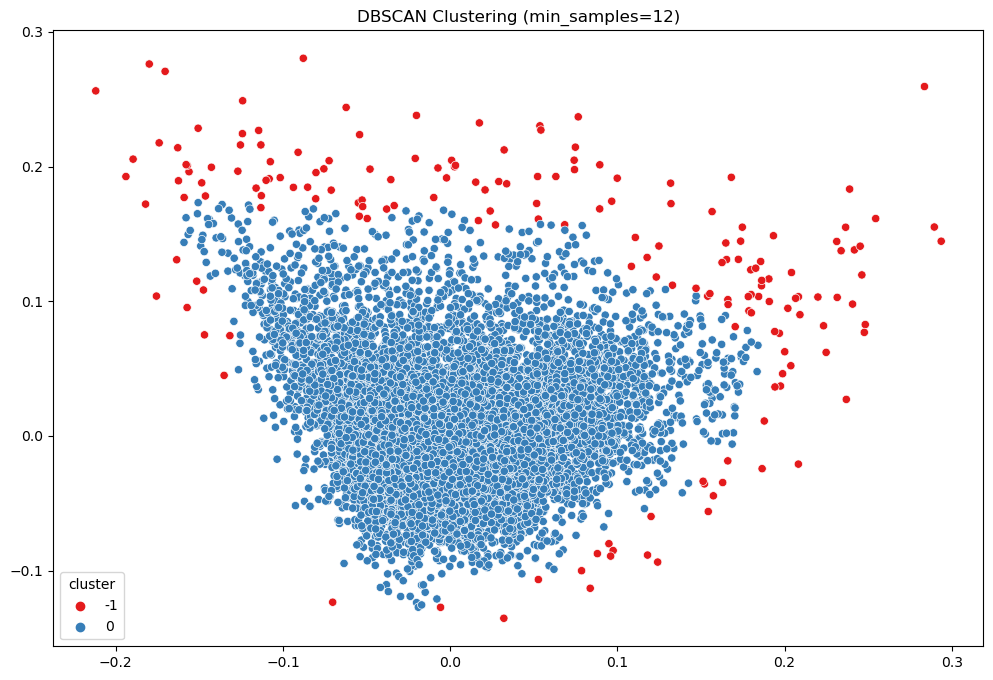

In [56]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_samples

# Experiment with different min_samples values
# min_samples starts from 4: As per the guideline of twice the number of dimensions
min_samples_values = [4, 6, 8, 12]

for min_samples_value in min_samples_values:
    # Initialize and fit DBSCAN model with varying min_samples and optimal epsilon
    dbscan_model = DBSCAN(eps=optimal_eps, min_samples=min_samples_value)
    dbscan_labels = dbscan_model.fit_predict(X_tfidf_pca)

    # Add DBSCAN labels to the dataframe
    data['cluster'] = dbscan_labels

    # Label outliers as -1 in the 'cluster' column
    data['cluster'] = np.where(data['cluster'] == -1, -1, data['cluster'])

    # Display the number of clusters created by DBSCAN
    num_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    print(f"min_samples = {min_samples_value}")
    print(f"Number of clusters created: {num_clusters_dbscan}")

    # Calculate silhouette samples
    silhouette_vals = silhouette_samples(X_tfidf_pca, dbscan_labels)

    # Calculate average silhouette score
    avg_silhouette_score = silhouette_vals.mean()
    print(f"Silhouette Score: {avg_silhouette_score}")

    # Visualize the clusters using a scatter plot
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x=X_tfidf_pca[:, 0], y=X_tfidf_pca[:, 1], hue='cluster', palette='Set1', data=data, legend='full')
    plt.title(f'DBSCAN Clustering (min_samples={min_samples_value})')
    plt.show()
